# Emotion Words & Description Density

**Goal:** Count color terms and compare description density.

# Setup: Load Texts

This notebook needs **Crime And Punishment**

**How to provide the texts:**
1. Download the book from Project Gutenberg as txts. [go to https://www.gutenberg.org/ebooks/2554 ]

2. Place the text file in the "data" folder with name:
   - `Crime-punishment.txt`  (Crime And Punishment)



In [1]:
import re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path

def load_texts(local_crime: str = '../data/Crime-punishment.txt'):
    """Load Crime and Punishment text from disk.

    Parameters
    ----------
    local_crime : str
        Path to Crime and Punishment text file. Defaults to '../data/Crime-punishment.txt'.

    Returns
    -------
    str
        crime_text.

    Raises
    ------
    FileNotFoundError
        If the file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1 = Path(local_crime)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Crime-punishment.txt' at this path or update load_texts(...)."
        )

    # Read the file (UTF-8; ignore undecodable bytes to stay robust)
    crime = p1.read_text(encoding='utf-8', errors='ignore')
    return crime

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('*** START')
    end   = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')

# Load raw Crime and Punishment text (forgiving: returns '' if the file is missing)
crime_raw = load_texts()

# Normalize for tokenization
crime = normalize(crime_raw)

print(f"Crime and Punishment chars: {len(crime):,}")


Crime and Punishment chars: 1,211,670


### Helpers: Tokenization

In [4]:
import re

WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries.

    Uses a regex to split on '.', '!', '?' followed by whitespace.
    Because this is heuristic, treat results as approximate.

    Returns
    -------
    list[str]
        Sentence-like strings.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

# Tokenizing the text for Crime and Punishment only
crime_words = words(crime)

# Splitting the text into sentences for Crime and Punishment only
crime_sentences = sentences(crime)

# Printing word and sentence counts for Crime and Punishment only
print(f"Crime and Punishment words: {len(crime_words):,}")
print(f"Crime and Punishment sentences: {len(crime_sentences):,}")

Crime and Punishment words: 212,681
Crime and Punishment sentences: 16,927


### Count Color Terms

Crime and Punishment top emotions: [('love', 74), ('doubt', 51), ('despair', 39), ('hope', 34), ('suffering', 31), ('fear', 28), ('pride', 20), ('faith', 19), ('anger', 19), ('happiness', 15), ('peace', 15), ('joy', 14), ('freedom', 11), ('sacrifice', 10), ('guilt', 3)] | rate per 100k: 181.49246994324835


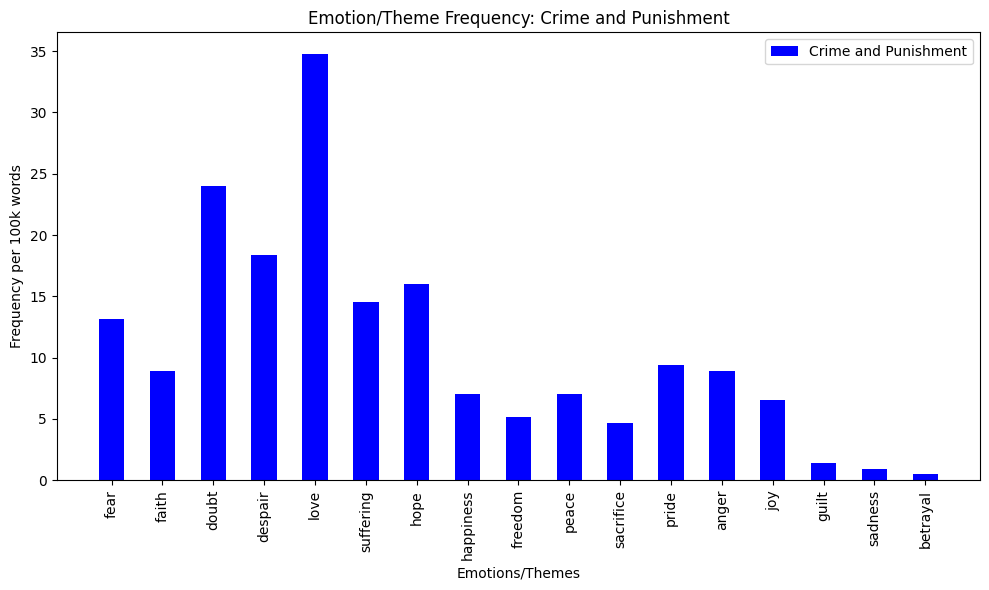

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Define emotion or theme-related words (replace with any themes you'd like to track)
EMOTION_LIST = {
    'joy', 'anger', 'sadness', 'guilt', 'love', 'fear', 'happiness', 'suffering', 'hope', 'despair',
    'redemption', 'envy', 'pride', 'peace', 'betrayal', 'sacrifice', 'freedom', 'doubt', 'faith', 'rebellion'
}

# Count emotion or theme words
def count_emotions(tokens, emotion_list=EMOTION_LIST):
    c = Counter(w for w in tokens if w in emotion_list)
    return c, sum(c.values()), len(tokens)

# Count emotions for Crime and Punishment only
a_emotions, a_hits, a_total = count_emotions(crime_words)

# Print top emotions and rate per 100k for Crime and Punishment only
print("Crime and Punishment top emotions:", a_emotions.most_common(15), "| rate per 100k:", (a_hits/a_total)*100000)

# Normalize emotion counts per 100k words for Crime and Punishment
a_emotions_normalized = {emotion: (count / a_total) * 100000 for emotion, count in a_emotions.items()}

# Plotting only for Crime and Punishment
plt.figure(figsize=(10, 6))

# Bar plot for Crime and Punishment emotions
index = range(len(a_emotions_normalized))

plt.bar(index, list(a_emotions_normalized.values()), width=0.5, label="Crime and Punishment", color='blue')

plt.xlabel('Emotions/Themes')
plt.ylabel('Frequency per 100k words')
plt.title('Emotion/Theme Frequency: Crime and Punishment')
plt.xticks(index, list(a_emotions_normalized.keys()), rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Rolling emotion windows for *Crime and Punishment* only
def rolling_emotion_windows(tokens, window=800, step=200, emotion_list=EMOTION_LIST):
    hits_per_window = []
    for i in range(0, max(1, len(tokens)-window+1), step):
        chunk = tokens[i:i+window]
        c = sum(1 for w in chunk if w in emotion_list)  # count the emotions/themes in the window
        hits_per_window.append((i, i+window, c, c * (100000/window)))  # per 100k
    return hits_per_window

# Nearest sentence span (for previewing emotional/thematic bursts)
def nearest_sentence_span(tokens, sents, start_idx, end_idx):
    text = " ".join(tokens[start_idx:end_idx])
    head = " ".join(tokens[start_idx:start_idx+20])
    for k, s in enumerate(sents):
        if head[:50] in s:
            j0 = max(0, k-1); j1 = min(len(sents), k+3)
            return j0, j1, " ".join(sents[j0:j1])
    return None, None, text[:500]

# Run emotion/theme analysis for Crime and Punishment only
w_roll = rolling_emotion_windows(crime_words, window=800, step=200)

# Top 5 bursts by per-100k for Crime and Punishment
w_top = sorted(w_roll, key=lambda x: x[3], reverse=True)[:5]

# Print emotional/theme bursts for Crime and Punishment only
print("=== Crime and Punishment emotion bursts ===")
for a, b, h, rate in w_top:
    j0, j1, preview = nearest_sentence_span(crime_words, crime_sentences, a, b)
    print(f"[tokens {a}-{b}] hits={h} | {rate:.0f} per 100k")
    print(preview[:400], "…\n")

=== Crime and Punishment emotion bursts ===
[tokens 18200-19000] hits=8 | 1000 per 100k
bread and water she would not sell her soul she would not barter her moral freedom for comfort she would not barter it for all schleswig holstein much less mr luzhin s money no dounia was not that sort when i knew her and she is still the same of course yes there s no denying the svidriga lovs are a bitter pill it s a bitter thing to spend one s life a governess in the provinces for two hundred ro …

[tokens 211600-212400] hits=8 | 1000 per 100k
and sometimes did not offer it at all as though afraid he would repel it he always took her hand as though with repugnance always seemed vexed to meet her and was sometimes obstinately silent throughout her visit sometimes she trembled epilogue before him and went away deeply grieved but now their hands did not part he stole a rapid glance at her and dropped his eyes on the ground without speaking …

[tokens 18000-18800] hits=7 | 875 per 100k
did not know yo

Using JSON: Character Library/Crime_punishment.json
Using text: ../data/Crime-punishment.txt

Character aliases (preview):
- Rodion_Raskolnikov: ['Raskolnikov', 'Rodion Romanovich Raskolnikov', 'Rodion Romanovich', 'Rodion', 'Rodya'] ...
- Sonia_Marmeladov: ['Sonia', 'Sonya', 'Sofya Semyonovna Marmeladov', 'Sofya Semyonovna', 'Marmeladova'] ...
- Avdotya_Raskolnikov: ['Dunya', 'Dounia', 'Avdotya Romanovna Raskolnikov', 'Avdotya Romanovna', 'Raskolnikova'] ...
- Arkady_Svidrigailov: ['Svidrigailov', 'Arkady Ivanovich Svidrigailov', 'Arkady Ivanovich', 'Arkady', 'the landowner'] ...
- Dmitri_Razumikhin: ['Razumikhin', 'Dmitri Prokofych Razumikhin', 'Dmitri Prokofych', 'Prokofych', 'Vrazumikhin'] ...

Number of sentences: 15088
First 3 sentences:
- chapter i    On an exceptionally hot evening early in July a young man came out of the garret in which he lodged in S. Place and walked slowly, as though in hesitation, towards K. bridge.
- He had successfully avoided meeting his land- lady on 

,character_id,sentence,compound,polarity,pos_count,neg_count
0,Rodion_Raskolnikov,"And each time he passed, the young man had a s...",-1.0,negative,0,2
1,Rodion_Raskolnikov,"Yes, maybe it is a plaything.” ...",0.0,neutral,0,0
2,Rodion_Raskolnikov,An expression of the profoundest disgust gleam...,-1.0,negative,0,1
3,Rodion_Raskolnikov,But there was such accumulated bitterness and ...,0.0,neutral,0,0
4,Rodion_Raskolnikov,"And yet when a drunken man who, for some unkno...",0.0,neutral,0,0



=== Polarity Counts per Character ===


polarity,character_id,negative,neutral,positive
0,Arkady_Svidrigailov,1,10,0
1,Avdotya_Raskolnikov,40,344,38
2,Dmitri_Razumikhin,3,49,1
3,Rodion_Raskolnikov,88,895,52
4,Sonia_Marmeladov,45,387,23



=== Average Sentiment Scores per Character ===


,character_id,compound,pos_count,neg_count
0,Arkady_Svidrigailov,-0.090909,0.000000,0.090909
1,Avdotya_Raskolnikov,-0.003160,0.137441,0.130332
2,Dmitri_Razumikhin,-0.037736,0.018868,0.056604
3,Rodion_Raskolnikov,-0.034783,0.058937,0.091787
4,Sonia_Marmeladov,-0.046886,0.072527,0.114286


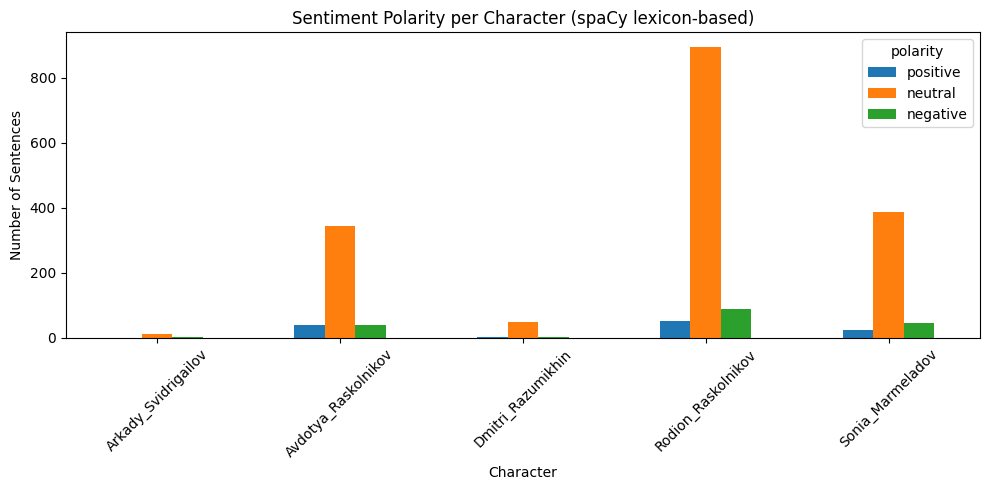


--- Rodion_Raskolnikov | NEGATIVE examples ---
- And each time he passed, the young man had a sick, frightened feeling, which made him scowl and feel ashamed.

- An expression of the profoundest disgust gleamed for a moment in the young man’s refined face.

- “A rouble and a half!” cried the young man.


--- Rodion_Raskolnikov | POSITIVE examples ---
- The young man was very glad to meet none of them, and at once slipped unnoticed through the door on the right, and up the staircase.

- I am in complete agreement with her, Rodya, and share all her plans and hopes, and think there is every probability of realising them.

- If possible, I would settle somewhere near you, for the most joyful piece of news, dear Rodya, I have kept for the end of my letter, know then, my dear boy, that we may, perhaps, be all together in a very short time and may embrace one another again after a separation of almost three years!


--- Sonia_Marmeladov | NEGATIVE examples ---
- “Polenka,” cried Katerina Iva

In [7]:
# ==========================================
# Crime and Punishment - Character Emotion Analysis
# spaCy + custom sentiment lexicon, all in one cell
# ==========================================

import json
import re
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import spacy
from IPython.display import display

# -------------------------------
# Load spaCy model
# -------------------------------
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    raise OSError(
        "spaCy model 'en_core_web_sm' is not installed.\n"
        "Run this once in a separate cell or terminal:\n"
        "!python -m spacy download en_core_web_sm"
    )

# Allow long novel text
nlp.max_length = 2_000_000  # increase if needed

# -------------------------------
# Paths (relative to THIS notebook)
# -------------------------------
JSON_PATH = "Character Library/Crime_punishment.json"
TEXT_PATH = "../data/Crime-punishment.txt"

print("Using JSON:", JSON_PATH)
print("Using text:", TEXT_PATH)

# -------------------------------
# Load character alias metadata
# -------------------------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    characters = json.load(f)

# Top 5 characters to analyze
top5_ids = [
    "Rodion_Raskolnikov",
    "Sonia_Marmeladov",
    "Avdotya_Raskolnikov",
    "Arkady_Svidrigailov",
    "Dmitri_Razumikhin",
]

# Build alias lists
char_aliases = {}
for cid in top5_ids:
    alias_list = []
    for item in characters[cid]["aliases"]:
        if isinstance(item, str):
            alias_list.append(item)
        else:
            # entries like {"text": "...", "tier": 3}
            alias_list.append(item["text"])
    char_aliases[cid] = alias_list

print("\nCharacter aliases (preview):")
for cid, als in char_aliases.items():
    print(f"- {cid}: {als[:5]} ...")

# -------------------------------
# Load the novel text
# -------------------------------
with open(TEXT_PATH, "r", encoding="utf-8") as f:
    full_text = f.read()

# -------------------------------
# Sentence segmentation with spaCy
# -------------------------------
doc = nlp(full_text)

sentences = [
    {"id": i, "text": sent.text.replace("\n", " ").strip()}
    for i, sent in enumerate(doc.sents)
    if sent.text.strip()
]

print("\nNumber of sentences:", len(sentences))
print("First 3 sentences:")
for s in sentences[:3]:
    print("-", s["text"])

# -------------------------------
# Helper: does a sentence mention a character?
# -------------------------------
def sentence_mentions_character(sentence_text, aliases):
    text_lower = sentence_text.lower()
    for alias in aliases:
        alias_lower = alias.lower()
        pattern = r"\b" + re.escape(alias_lower) + r"\b"
        if re.search(pattern, text_lower):
            return True
    return False

# Map sentences to characters
char_sentences = defaultdict(list)
for sent in sentences:
    s_text = sent["text"]
    for cid, aliases in char_aliases.items():
        if sentence_mentions_character(s_text, aliases):
            char_sentences[cid].append(s_text)

print("\nNumber of sentences per character (mentions):")
for cid in top5_ids:
    print(f"- {cid}: {len(char_sentences[cid])}")

# -------------------------------
# Simple lexicon-based sentiment
# -------------------------------
positive_words = {
    "happy", "glad", "joy", "joyful", "love", "loved", "loving", "kind",
    "hope", "hopeful", "relief", "relieved", "peace", "peaceful",
    "smile", "smiled", "smiling", "gentle", "compassion", "compassionate",
    "warm", "warmth", "comfort", "comforted", "strong", "brave",
    "courage", "courageous", "forgive", "forgiveness", "redeemed",
    "tender", "tenderness", "affection", "calm", "serene"
}

negative_words = {
    "fear", "afraid", "terrified", "horror", "horrible", "horrid",
    "anxious", "anxiety", "despair", "desperate", "sad", "sorrow",
    "miserable", "misery", "guilt", "guilty", "shame", "ashamed",
    "anger", "angry", "rage", "furious", "hate", "hated", "hateful",
    "disgust", "disgusted", "loathing", "torment", "pain", "suffer",
    "suffering", "wretched", "hopeless", "frightened", "cry", "wept",
    "tears", "weak", "humiliated"
}

def score_sentence_lexicon(sentence, nlp_model):
    """Return (compound, pos_count, neg_count) for a sentence."""
    doc = nlp_model(sentence)
    pos_count = 0
    neg_count = 0
    for token in doc:
        if not token.is_alpha:
            continue
        lemma = token.lemma_.lower()
        if lemma in positive_words:
            pos_count += 1
        elif lemma in negative_words:
            neg_count += 1
    total = pos_count + neg_count
    compound = 0.0 if total == 0 else (pos_count - neg_count) / total
    return compound, pos_count, neg_count

def classify_polarity(compound, pos_th=0.1, neg_th=-0.1):
    if compound >= pos_th:
        return "positive"
    elif compound <= neg_th:
        return "negative"
    else:
        return "neutral"

# -------------------------------
# Compute sentiment per character sentence
# -------------------------------
results = []

for cid in top5_ids:
    for s in char_sentences[cid]:
        compound, pos_ct, neg_ct = score_sentence_lexicon(s, nlp)
        polarity = classify_polarity(compound)
        results.append({
            "character_id": cid,
            "sentence": s,
            "compound": compound,
            "polarity": polarity,
            "pos_count": pos_ct,
            "neg_count": neg_ct
        })

sent_df = pd.DataFrame(results)
print("\nSentiment dataframe shape:", sent_df.shape)
display(sent_df.head())

# -------------------------------
# Aggregated stats per character
# -------------------------------
polarity_counts = (
    sent_df.groupby(["character_id", "polarity"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

avg_scores = (
    sent_df.groupby("character_id")[["compound", "pos_count", "neg_count"]]
    .mean()
    .reset_index()
)

print("\n=== Polarity Counts per Character ===")
display(polarity_counts)

print("\n=== Average Sentiment Scores per Character ===")
display(avg_scores)

# -------------------------------
# Visualization
# -------------------------------
plot_df = polarity_counts.set_index("character_id")

# Ensure all columns exist
for col in ["positive", "neutral", "negative"]:
    if col not in plot_df.columns:
        plot_df[col] = 0

plot_df[["positive", "neutral", "negative"]].plot(kind="bar", figsize=(10, 5))
plt.title("Sentiment Polarity per Character (spaCy lexicon-based)")
plt.xlabel("Character")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Example sentences
# -------------------------------
def show_examples(character, polarity="negative", n=3):
    subset = sent_df[
        (sent_df["character_id"] == character) &
        (sent_df["polarity"] == polarity)
    ].sort_values("compound")
    print(f"\n--- {character} | {polarity.upper()} examples ---")
    for _, row in subset.head(n).iterrows():
        print(f"- {row['sentence']}\n")

for cid in top5_ids:
    show_examples(cid, "negative", n=3)
    show_examples(cid, "positive", n=3)


Using JSON: Character Library/Crime_punishment.json
Using text: ../data/Crime-punishment.txt

Raskolnikov aliases (preview): ['Raskolnikov', 'Rodion Romanovich Raskolnikov', 'Rodion Romanovich', 'Rodion', 'Rodya', 'Rodka', 'Rodenka', 'the student', 'the young man', 'the lodger'] ...

Total number of sentences: 15088
First 3 sentences:
- chapter i    On an exceptionally hot evening early in July a young man came out of the garret in which he lodged in S. Place and walked slowly, as though in hesitation, towards K. bridge.
- He had successfully avoided meeting his land- lady on the staircase.
- His garret was under the roof of a high, five-storied house and was more like a cupboard than a room.

Number of sentences mentioning Raskolnikov: 1035
First 3 Raskolnikov sentences:
- And each time he passed, the young man had a sick, frightened feeling, which made him scowl and feel ashamed.
- Yes, maybe it is a plaything.”                                 3                  fyodor dostoevsky   

,char_order,global_sent_id,sentence,main_emotion,total_emotion_hits,joy,calm,guilt,love,horror,suffering,anxiety,doubt,anger,justice,faith,regret
0,0,4,"And each time he passed, the young man had a s...",guilt,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,28,"Yes, maybe it is a plaything.” ...",horror,1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,30,An expression of the profoundest disgust gleam...,none,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,38,But there was such accumulated bitterness and ...,none,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,40,"And yet when a drunken man who, for some unkno...",none,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,64,The young man was very glad to meet none of th...,joy,1,1,0,0,0,0,0,0,0,0,0,0,0
6,6,78,"The young man stepped into the dark entry, whi...",none,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,84,The young man must have looked at her with a r...,none,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,85,"“Raskolnikov, a student, I came here a month a...",none,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,88,"I am again on the same errand,” Raskolnikov co...",justice,2,0,0,0,0,0,0,0,0,0,2,0,0



=== Total emotion counts for Raskolnikov ===


,emotion,total_count
0,justice,115
1,joy,70
2,calm,46
3,love,34
4,faith,32
5,anxiety,22
6,doubt,21
7,anger,19
8,horror,12
9,suffering,7


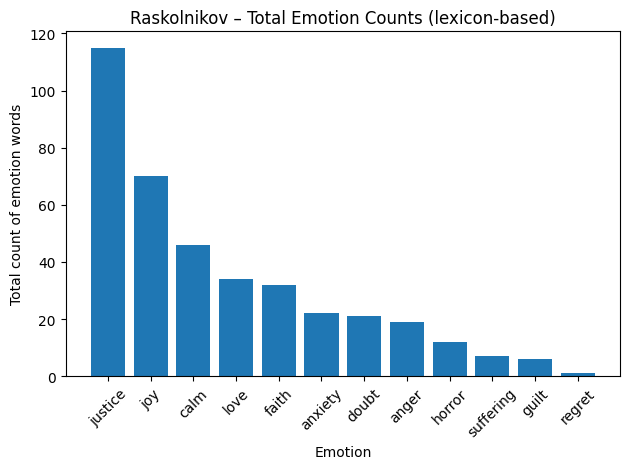


=== Emotion counts per story segment (bin) ===


,joy,calm,guilt,love,horror,suffering,anxiety,doubt,anger,justice,faith,regret
bin,,,,,,,,,,,,
0,2,0,2,1,1,0,1,1,1,4,3,0
1,3,1,0,13,0,1,0,0,1,10,3,0
2,2,3,0,0,2,0,1,1,0,5,1,0
3,0,4,0,2,1,1,1,0,0,4,0,0
4,2,2,0,1,1,1,0,1,1,4,2,0
5,3,1,0,1,0,0,2,0,2,2,0,0
6,4,2,0,0,0,0,0,0,0,8,4,0
7,6,1,0,1,0,0,2,3,1,6,3,0
8,4,5,0,1,0,1,2,1,0,6,0,0


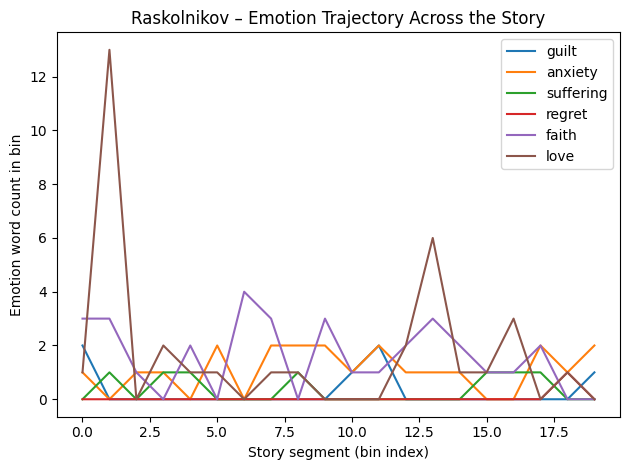


--- Example sentences where main emotion = GUILT ---
[#0] And each time he passed, the young man had a sick, frightened feeling, which made him scowl and feel ashamed.

[#42] And you, are you not ashamed?” — she pounced all at once upon Raskolnikov — “from the tavern!

[#552] By the way, do you remem- ber, Rodion Romanovitch, how a few years ago, in those days of beneficent publicity, a nobleman, I’ve forgotten his name, was put to shame everywhere, in all the papers, for having thrashed a German woman in the railway train.


--- Example sentences where main emotion = ANXIETY ---
[#30] (for my daughter has a yellow passport),” he added in parenthesis, looking with a certain uneasiness at the young man.

[#364] Though Pulcheria Alexandrovna felt that the young man was really too eccentric and pinched her hand too much, in her anxiety over her Rodya she looked on his presence as providential, and was unwilling to notice all his peculiarities.

[#419] “Then what is your decision, Rodya?”

In [8]:
# ==========================================
# Raskolnikov Emotion Analysis (12 emotions)
# Joy, calm, guilt, love, horror, suffering,
# anxiety, doubt, anger, justice, faith, regret
# ==========================================

import json
import re
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import spacy
from IPython.display import display

# -------------------------------
# Load spaCy model
# -------------------------------
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    raise OSError(
        "spaCy model 'en_core_web_sm' is not installed.\n"
        "Run this once in a separate cell or terminal:\n"
        "!python -m spacy download en_core_web_sm"
    )

# Allow long novel text
nlp.max_length = 2_000_000  # increase if needed

# -------------------------------
# Paths (relative to THIS notebook)
# -------------------------------
JSON_PATH = "Character Library/Crime_punishment.json"
TEXT_PATH = "../data/Crime-punishment.txt"

print("Using JSON:", JSON_PATH)
print("Using text:", TEXT_PATH)

# -------------------------------
# Load character alias metadata
# -------------------------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    characters = json.load(f)

# Focus ONLY on Raskolnikov
MAIN_CHAR_ID = "Rodion_Raskolnikov"

aliases = []
for item in characters[MAIN_CHAR_ID]["aliases"]:
    if isinstance(item, str):
        aliases.append(item)
    else:
        aliases.append(item["text"])

print("\nRaskolnikov aliases (preview):", aliases[:10], "...")

# -------------------------------
# Load the novel text
# -------------------------------
with open(TEXT_PATH, "r", encoding="utf-8") as f:
    full_text = f.read()

# -------------------------------
# Sentence segmentation with spaCy
# -------------------------------
doc = nlp(full_text)

sentences = [
    {"global_id": i, "text": sent.text.replace("\n", " ").strip()}
    for i, sent in enumerate(doc.sents)
    if sent.text.strip()
]

print("\nTotal number of sentences:", len(sentences))
print("First 3 sentences:")
for s in sentences[:3]:
    print("-", s["text"])

# -------------------------------
# Helper: does a sentence mention Raskolnikov?
# -------------------------------
def sentence_mentions_character(sentence_text, aliases):
    text_lower = sentence_text.lower()
    for alias in aliases:
        alias_lower = alias.lower()
        pattern = r"\b" + re.escape(alias_lower) + r"\b"
        if re.search(pattern, text_lower):
            return True
    return False

# Collect only Raskolnikov sentences, preserving order
rasko_sentences = []
for s in sentences:
    if sentence_mentions_character(s["text"], aliases):
        rasko_sentences.append(s)

print("\nNumber of sentences mentioning Raskolnikov:", len(rasko_sentences))
print("First 3 Raskolnikov sentences:")
for s in rasko_sentences[:3]:
    print("-", s["text"])

# -------------------------------
# Emotion lexicons (by lemma)
# -------------------------------
emotion_lexicon = {
    "joy": {
        "joy", "happy", "glad", "delight", "delighted",
        "pleasure", "cheerful", "rejoice", "smile", "laugh"
    },
    "calm": {
        "calm", "quiet", "peace", "peaceful", "still",
        "serene", "composed", "tranquil", "rest"
    },
    "guilt": {
        "guilt", "guilty", "remorse", "contrition",
        "repent", "repentance", "ashamed", "shame"
    },
    "love": {
        "love", "loved", "loving", "affection",
        "tenderness", "dear", "darling", "devotion"
    },
    "horror": {
        "horror", "horrible", "horrid", "terrible",
        "terrify", "terrified", "terror", "ghastly",
        "nightmare"
    },
    "suffering": {
        "suffer", "suffering", "torment", "agony",
        "pain", "misery", "wretched", "martyr", "martyrdom"
    },
    "anxiety": {
        "anxiety", "anxious", "nervous", "uneasy",
        "uneasiness", "restless", "dread", "worry",
        "worried", "apprehension"
    },
    "doubt": {
        "doubt", "doubtful", "uncertain", "uncertainty",
        "hesitate", "hesitation", "question", "suspicion",
        "suspicious"
    },
    "anger": {
        "anger", "angry", "enrage", "furious", "fury",
        "indignant", "indignation", "rage", "irritated"
    },
    "justice": {
        "justice", "just", "punish", "punishment",
        "innocent", "innocence", "crime", "law",
        "judgment", "judge", "sentence"
    },
    "faith": {
        "faith", "believe", "belief", "god", "cross",
        "prayer", "pray", "christ", "christian",
        "gospel", "bible", "church", "sin", "soul",
        "salvation"
    },
    "regret": {
        "regret", "repent", "repentance", "sorry",
        "lament", "bewail"
    }
}

emotion_names = [
    "joy", "calm", "guilt", "love", "horror", "suffering",
    "anxiety", "doubt", "anger", "justice", "faith", "regret"
]

# -------------------------------
# Score each Raskolnikov sentence for emotions
# -------------------------------
def score_emotions(sentence, nlp_model, emotion_lexicon):
    """Return dict: emotion -> count of matching lemmas in sentence."""
    doc = nlp_model(sentence)
    counts = {emo: 0 for emo in emotion_lexicon.keys()}
    for token in doc:
        if not token.is_alpha:
            continue
        lemma = token.lemma_.lower()
        for emo, lex in emotion_lexicon.items():
            if lemma in lex:
                counts[emo] += 1
    return counts

rows = []
for idx, s in enumerate(rasko_sentences):
    text = s["text"]
    global_id = s["global_id"]
    emo_counts = score_emotions(text, nlp, emotion_lexicon)
    total_hits = sum(emo_counts.values())
    if total_hits > 0:
        main_emotion = max(emo_counts, key=lambda e: emo_counts[e])
    else:
        main_emotion = "none"
    row = {
        "char_order": idx,           # order of this sentence among Raskolnikov sentences
        "global_sent_id": global_id,
        "sentence": text,
        "main_emotion": main_emotion,
        "total_emotion_hits": total_hits
    }
    for emo in emotion_names:
        row[emo] = emo_counts[emo]
    rows.append(row)

emo_df = pd.DataFrame(rows)

print("\nRaskolnikov emotion dataframe shape:", emo_df.shape)
display(emo_df.head(10))

# -------------------------------
# Overall emotion profile (totals)
# -------------------------------
total_per_emotion = emo_df[emotion_names].sum().sort_values(ascending=False)
total_df = total_per_emotion.reset_index()
total_df.columns = ["emotion", "total_count"]

print("\n=== Total emotion counts for Raskolnikov ===")
display(total_df)

# Bar chart: overall emotion strengths
plt.figure()
plt.bar(total_df["emotion"], total_df["total_count"])
plt.title("Raskolnikov – Total Emotion Counts (lexicon-based)")
plt.xlabel("Emotion")
plt.ylabel("Total count of emotion words")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Emotion trajectory over the story
# -------------------------------
# Bin Raskolnikov sentences into N segments of the story
N_BINS = 20 if len(emo_df) >= 20 else max(1, len(emo_df))

bin_size = len(emo_df) / N_BINS
bin_indices = []
for i in range(len(emo_df)):
    b = int(i / bin_size)
    if b >= N_BINS:
        b = N_BINS - 1
    bin_indices.append(b)

emo_df["bin"] = bin_indices

# Sum emotion counts per bin
bin_agg = emo_df.groupby("bin")[emotion_names].sum()

print("\n=== Emotion counts per story segment (bin) ===")
display(bin_agg)

# Plot trajectory for key emotions (to keep it readable)
key_emotions = ["guilt", "anxiety", "suffering", "regret", "faith", "love"]

plt.figure()
for emo in key_emotions:
    if emo in bin_agg.columns:
        plt.plot(bin_agg.index, bin_agg[emo], label=emo)

plt.title("Raskolnikov – Emotion Trajectory Across the Story")
plt.xlabel("Story segment (bin index)")
plt.ylabel("Emotion word count in bin")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Show some example sentences by main emotion
# -------------------------------
def show_examples_for_emotion(emotion, n=5):
    subset = emo_df[emo_df["main_emotion"] == emotion]
    print(f"\n--- Example sentences where main emotion = {emotion.upper()} ---")
    for _, row in subset.head(n).iterrows():
        print(f"[#{row['char_order']}] {row['sentence']}\n")

for emo in ["guilt", "anxiety", "suffering", "faith", "regret", "love"]:
    show_examples_for_emotion(emo, n=3)
